In [16]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from datetime import datetime
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import make_scorer
import seaborn as sns

In [93]:
def my_confusion_matrix(ytrue,ypred,labs=[1,0,-1]):
    from sklearn.metrics import confusion_matrix
    cols = ['Buy (p)','Hold (p)','Sell (p)']
    ind = ['Buy (t)','Hold (t)','Sell (t)']
    mat = confusion_matrix(ytrue,ypred,labs)
    return pd.DataFrame(mat, columns=cols,index=ind)

# trading loss for our own CV
def trading_loss(ytrue,ypred):
    conftrain = confusion_matrix(ytrue, ypred)
    loss = np.array([[0,1,2],[1,0,1],[2,1,0]])
    return np.sum(conftrain * loss)

# callable to score for CV
trade_scorer=make_scorer(trading_loss,greater_is_better=False)


def my_loss_summary(ytruetest, ytruetrain, ypredtest, ypredtrain):
    ytruetest=ytruetest[:-1]
    ypredtest=ypredtest[:-1]
    ytruetrain=ytruetrain[1:]
    ypredtrain=ypredtrain[1:]
    
    loss = np.array([[0,1,2],[1,0,1],[2,1,0]])
    days = len(ytruetest)
    losstrain = np.zeros(days)
    losstest = np.zeros(days)
    acctrain = np.zeros(days)
    acctest = np.zeros(days)
    acctrain1 = np.zeros(days)
    acctest1 = np.zeros(days)
    
    for i in range(days):
        conftrain = confusion_matrix(ytruetrain[i], ypredtrain[i])
        acctrain[i] = (conftrain[0,0] + conftrain[2,2])/np.sum(conftrain[0] + conftrain[2])
        acctrain1[i] = (conftrain[0,0] + conftrain[2,2])/np.sum(
            conftrain[0,0] + conftrain[0,2] + conftrain[2,0] + conftrain[2,2])
        losstrain[i] = np.sum(conftrain * loss)
        
        conftest = confusion_matrix(ytruetest[i], ypredtest[i])
        acctest[i] = ((conftest[0,0] + conftest[2,2])/
                      np.sum(conftest[0] + conftest[2]))
        acctest1[i] = (conftest[0,0] + conftest[2,2])/np.sum(
            conftest[0,0] + conftest[0,2] + conftest[2,0] + conftest[2,2])
        losstest[i] = np.sum(conftest * loss)
    
    
    ind = [i+1 for i in range(days)]
    col = ['Loss Train','Loss Test','Accuracy Train 1',
           'Accuracy Train 2','Accuracy Test 1',
           'Accuracy Test 2']
 
    plt.figure(figsize=(15,5))
    plt.plot(ind, losstrain, label='Loss (Train)')
    plt.plot(ind, losstest, label='Loss (Test)')
    plt.title('Loss by Day', fontsize=20)
    plt.xlabel("Day")
    plt.ylabel("Loss")
    plt.legend(prop={'size':15})
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(ind, acctrain, label='Trading Accuracy 1 (Train)')
    plt.plot(ind, acctest, label='Trading Accuracy 1 (Test)')
    plt.title('Trading Accuracy 1 by Day', fontsize=20)
    plt.xlabel("Day")
    plt.ylabel("Trading Accuracy 1")
    plt.legend(prop={'size':15})
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(ind, acctrain1, label='Trading Accuracy 2 (Train)')
    plt.plot(ind, acctest1, label='Trading Accuracy 2 (Test)')
    plt.xlabel("Day")
    plt.ylabel("Trading Accuracy 2")
    plt.title('Trading Accuracy 2 by Day', fontsize=20)
    plt.legend(prop={'size':15})
    plt.show()
    
    retv = zip(col,(losstrain, losstest, acctrain, acctrain1, acctest, acctest1))
    retdf = pd.DataFrame(dict(retv),index=ind)
    retdf = retdf.round({'Loss Train': 0, 'Loss Test': 0, 'Accuracy Train 1': 4,
                        'Accuracy Train 2': 4, 'Accuracy Test 1': 4, 'Accuracy Test 2': 4})
    
    avedf = pd.DataFrame(retdf.mean())
    avedf.columns = ['Averages']
    avedf = avedf.round(4)
    
    lossdf = retdf.iloc[:,0:2]
    accudf = retdf.iloc[:,[2,4]]
    accudf1 = retdf.iloc[:,[3,5]]
    
    ax1 = sns.heatmap(lossdf)
    ax1.set_title('Loss Heatmap')
    plt.show()
    ax2 = sns.heatmap(accudf)
    ax2.set_title('Trading Accuracy 1 Heatmap')
    plt.show()
    ax3 = sns.heatmap(accudf1)
    ax3.set_title('Trading Accuracy 2 Heatmap')
    plt.show()
    return (retdf, avedf)

def my_train_test_idx(DF,xlabs=['OI_a1'],ylabs=['signal6'],return_df=False,n_days=4):
    '''
    input your data frame and which x's you want to use
        as a list into xlabs
        
    return_df to return new data frame for CV
    return value is list of 2-tuples of train & test
        index iterables
        - pass directly into the cv parameter of cross_validate
    '''
    df = DF[['Date','Time']+xlabs+ylabs].dropna()
    
    #list of lengths of each day's data
    lengths = []
    for d in np.unique(DF['Date'].values)[:n_days]:
        lengths.append(df[df['Date']==d].shape[0])
    
    # where each day starts/ends
    bounds = np.cumsum(lengths)
    
    # list of 2-tuples of train & test indexes
    train_test_idx=[]
    prev=0
    for idx,val in enumerate(bounds[:-1]):
        train_id = np.arange(prev,val)
        test_id = np.arange(val,bounds[idx+1])
        prev = val
        train_test_idx.append((train_id,test_id))
    
    if return_df:
        return(train_test_idx,df)
    return (train_test_idx)

---

# Data

In [6]:
DF = pd.read_csv('ESH2019_final.csv',
                 index_col = 0,
                 dtype={'Time':str})

D:\Programs\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [35]:
# covariates to use
x_labs = ['OI_a1', 'OI_a2', 'OI_a3', 'OI_a4', 'OI_a5',
          'OI Ratio','OI_10ma','OI_20ma']


idx, df_cv = my_train_test_idx(DF,x_labs,return_df = True)

---

# Cross-Validating SVM

In [10]:
from sklearn.model_selection import GridSearchCV

# cross validate the penalty parameter
tune_params = {'C':np.logspace(-5,5,20)}

In [11]:
%%capture
cv_fit = GridSearchCV(svm.LinearSVC(dual=False,class_weight='balanced'),
                   tune_params,scoring=trade_scorer,cv=idx)
cv_fit.fit(df_cv[x_labs].values,y=df_cv['signal6'].values)

GridSearchCV(cv=[(array([    0,     1, ..., 50379, 50380]), array([ 50381,  50382, ..., 100761, 100762])), (array([ 50381,  50382, ..., 100761, 100762]), array([100763, 100764, ..., 151143, 151144])), (array([100763, 100764, ..., 151143, 151144]), array([151145, 151146, ..., 201525, 201526]))],
       error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 3.35982e-05, 1.12884e-04, 3.79269e-04, 1.27427e-03,
       4.28133e-03, 1.43845e-02, 4.83293e-02, 1.62378e-01, 5.45559e-01,
       1.83298e+00, 6.15848e+00, 2.06914e+01, 6.95193e+01, 2.33572e+02,
       7.84760e+02, 2.63665e+03, 8.85867e+03, 2.97635e+04, 1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_sco

In [12]:
best_C = cv_fit.best_params_['C']
cv_fit.best_params_

{'C': 1.8329807108324339}

---

# Testing on the Data Set

## Information to store

In [36]:
train_CFM  = []    # training confusion matrices
test_CFM   = []    # test confusion matrices

train_loss = []    # training loss
test_loss  = []    # test loss

y_pred_vec_tr = [] # training predictions
y_true_vec_tr = [] # true training values

y_pred_vec_te = [] # test predictions
y_true_vec_te = [] # true test predictions

svm_coefs = []     # coefficients for each fit

i_vec = my_train_test_idx(DF,x_labs,['signal6'],
                 return_df=False,
                 n_days=np.unique(DF['Date']).shape[0]
                )
test_idx = i_vec[3:]
df_test = df_cv.copy()

## Running Strategy on Test Data

In [38]:
###### TESTING ON THE DATA ######
sv_fit = svm.LinearSVC(C=best_C,dual=False,class_weight='balanced')
for i,j in tqdm(test_idx):
    X_train = df_test.iloc[i,:][x_labs].values
    y_train = df_test.iloc[i,:]['signal6'].values
    X_test = df_test.iloc[j,:][x_labs].values
    y_test = df_test.iloc[j,:]['signal6'].values
    
    sv_fit.fit(X_train,y_train)
    
    # coefficients for SVM
    svm_coefs.append(sv_fit.coef_)
    
    # predictions
    p_tr = sv_fit.predict(X_train)
    p_te = sv_fit.predict(X_test)
    
    y_pred_vec_tr.append(p_tr)
    y_pred_vec_te.append(p_te)
    
    y_true_vec_tr.append(y_train)
    y_true_vec_te.append(y_test)
    
    # confusion matrices
    train_CFM.append(my_confusion_matrix(y_train,p_tr,[1,0,-1]))
    test_CFM.append(my_confusion_matrix(y_test,p_te,[1,0,-1]))
    
    # loss
    train_loss.append(trading_loss(y_train,p_tr))
    test_loss.append(trading_loss(y_test,p_te))

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:26<00:00,  1.51it/s]


## Summary of Results

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in longlong_scalars


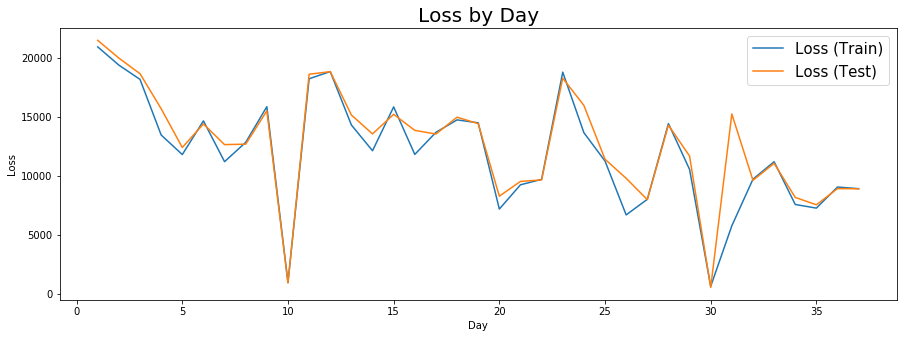

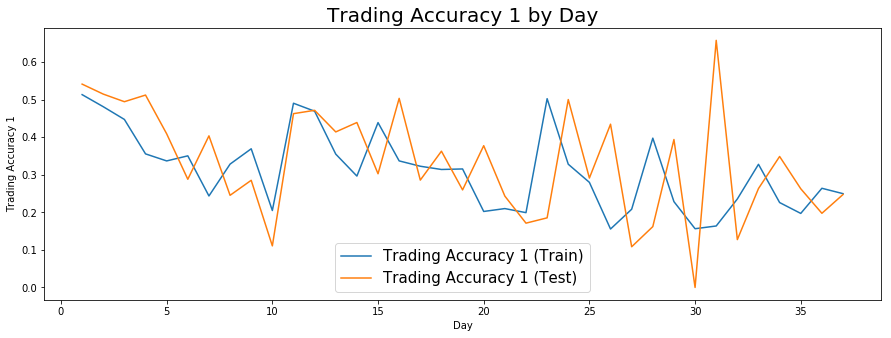

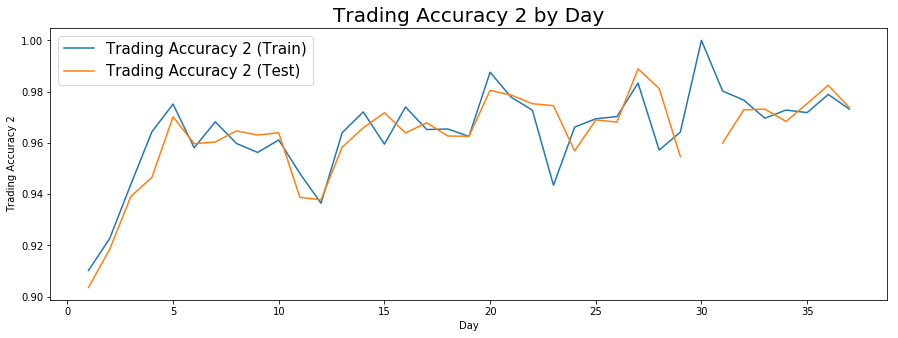

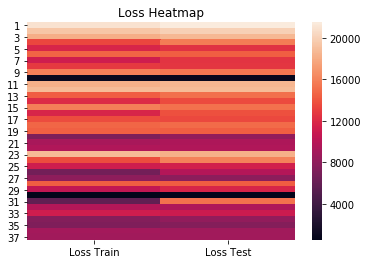

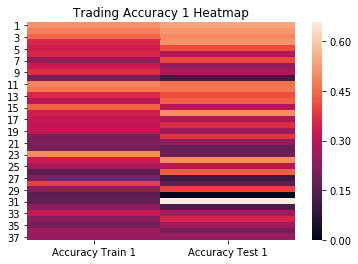

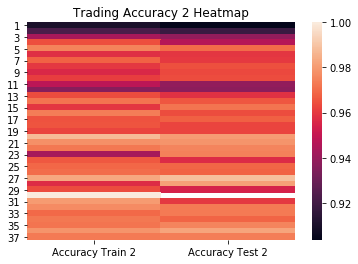

(    Loss Train  Loss Test  Accuracy Train 1  Accuracy Train 2  \
 1      20921.0    21476.0            0.5132            0.9103   
 2      19377.0    19971.0            0.4811            0.9227   
 3      18168.0    18649.0            0.4472            0.9438   
 4      13457.0    15681.0            0.3555            0.9643   
 5      11796.0    12396.0            0.3368            0.9751   
 6      14650.0    14391.0            0.3503            0.9581   
 7      11194.0    12639.0            0.2435            0.9682   
 8      12831.0    12678.0            0.3283            0.9598   
 9      15855.0    15503.0            0.3691            0.9563   
 10       957.0      910.0            0.2048            0.9612   
 11     18220.0    18605.0            0.4903            0.9481   
 12     18831.0    18823.0            0.4691            0.9365   
 13     14304.0    15150.0            0.3549            0.9640   
 14     12120.0    13546.0            0.2965            0.9721   
 15     15

In [94]:
my_loss_summary(y_true_vec_te,y_true_vec_tr,
                y_pred_vec_te,y_pred_vec_tr)

# Exploring Results

In [40]:
train_CFM[30]

,Buy (p),Hold (p),Sell (p)
Buy (t),58,235,0
Hold (t),115,11020,65
Sell (t),0,213,25


In [41]:
test_CFM[29]

,Buy (p),Hold (p),Sell (p)
Buy (t),0,293,0
Hold (t),0,11197,3
Sell (t),0,238,0


In [42]:
d = np.unique(df_test['Date'].values)
day_test = d[4:]
day_train = d[3:-1]

In [43]:
day_train[30]

'02/18/2019'

In [44]:
day_test[29]

'02/18/2019'

In [97]:
df_p = df_test[df_test['Date']==day_train[30]]
df_q = df_test[df_test['Date']==day_train[31]]
df_r = df_test[df_test['Date']=='01/21/2019']
df_base1 = df_test[df_test['Date']==day_train[25]]
df_base2 = df_test[df_test['Date']==day_train[15]]

In [46]:
df_p

,Date,Time,OI_a1,OI_a2,OI_a3,OI_a4,OI_a5,OI Ratio,OI_10ma,OI_20ma,signal6
2016060,02/18/2019,08:00:09.893,0.0,0.0,0.0,0.0,0.0,-0.231788,-0.2,-0.10,1.0
2016061,02/18/2019,08:00:10.425,-1.0,0.0,0.0,0.0,0.0,-0.234899,-0.2,-0.15,1.0
2016063,02/18/2019,08:00:11.692,0.0,0.0,-1.0,0.0,0.0,-0.082803,2.1,1.00,1.0
2016064,02/18/2019,08:00:11.881,22.0,0.0,0.0,-1.0,0.0,0.151079,5.5,2.70,1.0
2016065,02/18/2019,08:00:12.313,34.0,22.0,0.0,0.0,-1.0,-0.450980,8.3,4.10,1.0
2016066,02/18/2019,08:00:12.917,28.0,34.0,22.0,0.0,0.0,-0.338983,8.9,4.40,1.0
2016067,02/18/2019,08:00:13.376,6.0,28.0,34.0,22.0,0.0,-0.322034,9.1,4.50,1.0
2016068,02/18/2019,08:00:13.968,2.0,6.0,28.0,34.0,22.0,-0.268657,9.3,4.60,1.0
2016069,02/18/2019,08:00:14.453,2.0,2.0,6.0,28.0,34.0,-0.259259,9.4,4.65,1.0
2016070,02/18/2019,08:00:14.893,1.0,2.0,2.0,6.0,28.0,-0.259259,9.5,4.65,1.0


In [51]:
np.count_nonzero(df_p['OI_a1'].values)

5473

In [73]:
df_p['OI_a1'].shape

(11731, 11)

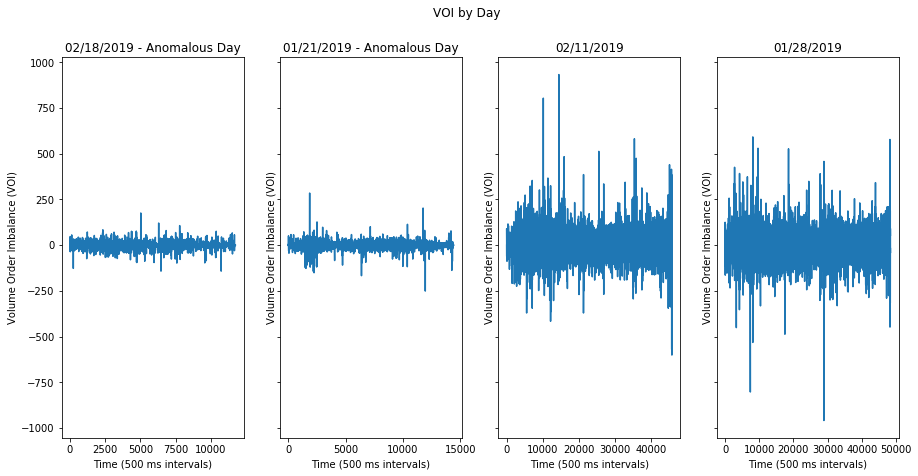

In [98]:
#temp = [df_p,df_q,df_base1]
temp = [df_p,df_r,df_base1, df_base2]

fig,ax = plt.subplots(1,len(temp),sharey=True,figsize=(15,7))
for i, P in enumerate(ax):
    extra = ''
    if i == 0 or i == 1:
        extra = ' - Anomalous Day'
    t = temp[i]
    x = range(t.shape[0])
    y = t['OI_a1'].values
    P.set_title(t['Date'].values[0] + extra)
    P.set_xlabel("Time (500 ms intervals)")
    P.set_ylabel("Volume Order Imbalance (VOI)")
    P.plot(x,y)
fig.suptitle("VOI by Day")
plt.show()

---

In [84]:
hold_te = [val.values[0,1] + val.values[2,1] for val in test_CFM]
invhold_te = [val.values[1,0]+val.values[1,2] for val in test_CFM]
bs_te = [val.values[0,0] + val.values[2,2] for val in test_CFM]

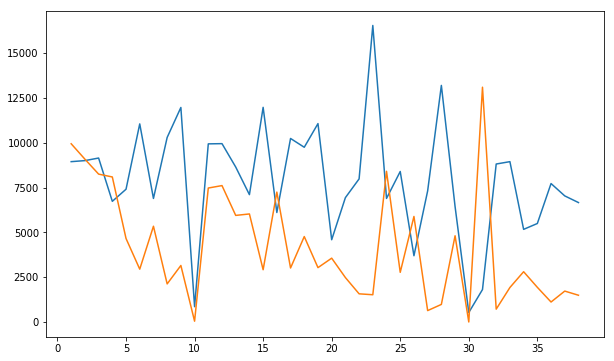

In [96]:
plt.figure(figsize=(10,6))
plt.plot(range(1,1+len(hold_te)),hold_te)
plt.plot(range(1,1+len(hold_te)),invhold_te)
plt.show()